In [ ]:
pip install pyspark

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import sys

try:

    # Create a SparkConf object
    conf = SparkConf() \
          .setAppName("dellsparkdemoapp") \
          .setMaster("local[*]")
                

    # Create a SparkSession object
    spark = SparkSession.builder.config(conf=conf) \
            .set("spark.sql.files.maxPartitionBytes", "1KB")\
            .getOrCreate()

    # Create DataFrame
    data = [("Paul","Amazon","Engg","USA"),
            ("Michael Dell","Dell","CEO","USA"),
            ("Justin","Greg","CTO","Germany"),
            ("Maria","Netflix","Finance","Ukraine"),
            ("Maria","Netflix","Finance","Ukraine"),
            ("Michael Dell","Dell","CEO","USA"),
            ("Maria","","Finance","Ukraine"),
            ("Jeff Bezos","Amazon","CEO","USA"),
            ("Justin","Starburst","CTO",None),
            ("Elon","Tesla","CEO","Germany"),
            ("Charles brian","Amazon","CTO","USA"),
            ("Jeff brian","Dell","CTO","USA"),
            ("Tom Greg","Dell","SVP","USA"),
        (None, None, None, None)
        ]

    columns = ["name", "company", "designation","country"]
    emp_df = spark.createDataFrame(data = data, schema = columns)

    if spark is None:
        print("Spark session not available")
        sys.exit(0)

except Exception as ex:
    print(ex)

emp_df.printSchema()


root
 |-- name: string (nullable = true)
 |-- company: string (nullable = true)
 |-- designation: string (nullable = true)
 |-- country: string (nullable = true)



In [2]:
if not emp_df.isEmpty == False:
    emp_df.show(truncate=False)

+-------------+---------+-----------+-------+
|name         |company  |designation|country|
+-------------+---------+-----------+-------+
|Paul         |Amazon   |Engg       |USA    |
|Michael Dell |Dell     |CEO        |USA    |
|Justin       |Greg     |CTO        |Germany|
|Maria        |Netflix  |Finance    |Ukraine|
|Maria        |Netflix  |Finance    |Ukraine|
|Michael Dell |Dell     |CEO        |USA    |
|Maria        |         |Finance    |Ukraine|
|Jeff Bezos   |Amazon   |CEO        |USA    |
|Justin       |Starburst|CTO        |null   |
|Elon         |Tesla    |CEO        |Germany|
|Charles brian|Amazon   |CTO        |USA    |
|Jeff brian   |Dell     |CTO        |USA    |
|Tom Greg     |Dell     |SVP        |USA    |
|null         |null     |null       |null   |
+-------------+---------+-----------+-------+



In [3]:
#get the number of partitions in the RDD
print(emp_df.rdd.getNumPartitions())

4


In [4]:
#Add a new column to the Spark dataframe
from pyspark.sql.functions import col,lit
emp_df = emp_df.withColumn('email', lit('dummy@dummyemail.com'))
emp_df.show()

+-------------+---------+-----------+-------+--------------------+
|         name|  company|designation|country|               email|
+-------------+---------+-----------+-------+--------------------+
|         Paul|   Amazon|       Engg|    USA|dummy@dummyemail.com|
| Michael Dell|     Dell|        CEO|    USA|dummy@dummyemail.com|
|       Justin|     Greg|        CTO|Germany|dummy@dummyemail.com|
|        Maria|  Netflix|    Finance|Ukraine|dummy@dummyemail.com|
|        Maria|  Netflix|    Finance|Ukraine|dummy@dummyemail.com|
| Michael Dell|     Dell|        CEO|    USA|dummy@dummyemail.com|
|        Maria|         |    Finance|Ukraine|dummy@dummyemail.com|
|   Jeff Bezos|   Amazon|        CEO|    USA|dummy@dummyemail.com|
|       Justin|Starburst|        CTO|   null|dummy@dummyemail.com|
|         Elon|    Tesla|        CEO|Germany|dummy@dummyemail.com|
|Charles brian|   Amazon|        CTO|    USA|dummy@dummyemail.com|
|   Jeff brian|     Dell|        CTO|    USA|dummy@dummyemail.

In [5]:
#Select only columns which are required 
emp_df.select(['name','company','email']).show()

+-------------+---------+--------------------+
|         name|  company|               email|
+-------------+---------+--------------------+
|         Paul|   Amazon|dummy@dummyemail.com|
| Michael Dell|     Dell|dummy@dummyemail.com|
|       Justin|     Greg|dummy@dummyemail.com|
|        Maria|  Netflix|dummy@dummyemail.com|
|        Maria|  Netflix|dummy@dummyemail.com|
| Michael Dell|     Dell|dummy@dummyemail.com|
|        Maria|         |dummy@dummyemail.com|
|   Jeff Bezos|   Amazon|dummy@dummyemail.com|
|       Justin|Starburst|dummy@dummyemail.com|
|         Elon|    Tesla|dummy@dummyemail.com|
|Charles brian|   Amazon|dummy@dummyemail.com|
|   Jeff brian|     Dell|dummy@dummyemail.com|
|     Tom Greg|     Dell|dummy@dummyemail.com|
|         null|     null|dummy@dummyemail.com|
+-------------+---------+--------------------+



In [6]:
#drop a column from the dataframe
emp_df= emp_df.drop('email')

In [7]:
#Group by and aggreate 
emp_df.groupby('company').agg({'name': 'count'}).show()

+---------+-----------+
|  company|count(name)|
+---------+-----------+
|     Greg|          1|
|     Dell|          4|
|   Amazon|          3|
|  Netflix|          2|
|         |          1|
|Starburst|          1|
|     null|          0|
|    Tesla|          1|
+---------+-----------+



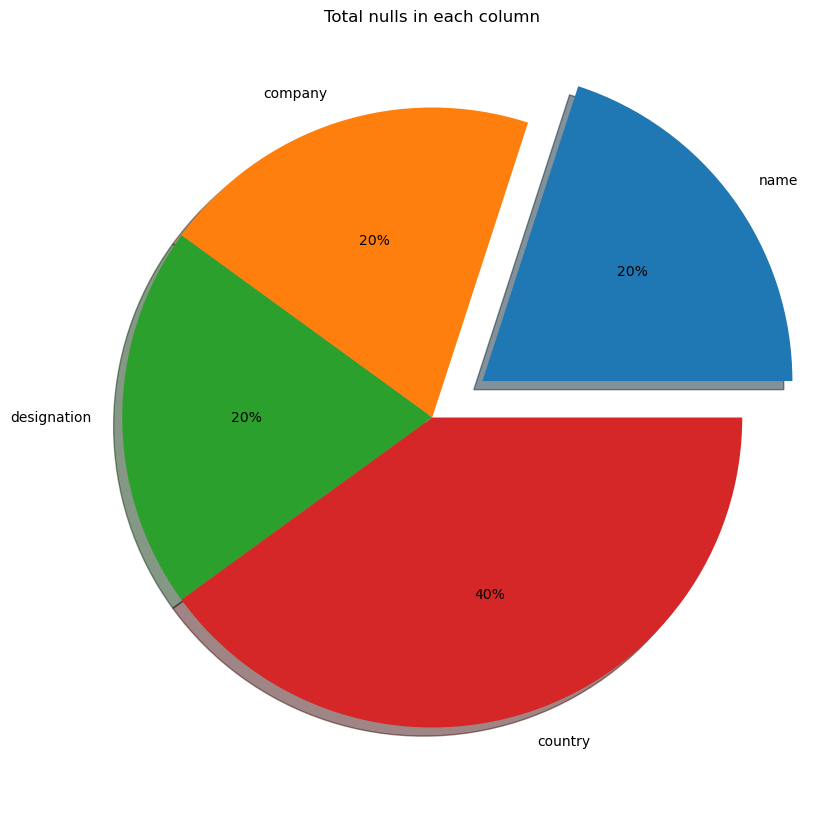

In [8]:
#Count total number of null values - EDA
import matplotlib.pyplot as plt
import pyspark.sql.functions as pfunc

null_value_list = list()

for col_ in emp_df.columns:
    dfemp= emp_df.where(pfunc.col(col_).isNull())
    null_value_list.append(dfemp.count())     

#print(null_value_list)                

plt.rcParams["figure.figsize"] = (10,12)

columns = [col_ for col_ in emp_df.columns]
myexplode = [0.2, 0, 0, 0]

plt.pie(null_value_list, labels = columns, explode = myexplode, shadow = True, autopct='%1.0f%%')
plt.title('Total nulls in each column')
plt.show()

In [9]:
#find how many duplicate row present
import pyspark.sql.functions as funcs
emp_df.groupBy(emp_df.columns).count().where(funcs.col('count') > 1).select(funcs.sum('count')).show()

+----------+
|sum(count)|
+----------+
|         4|
+----------+



In [10]:
#outlier detection - Z-Score
from pyspark.sql.functions import *
column_subset = emp_df.columns

emp_outlier_df=None

for col in column_subset:
    if emp_df.select(col).dtypes[0][1]=="string":
        pass
    else:
        mean = emp_df.select(mean(col)).collect()[0][0]
        stddev = emp_df.select(stddev(col)).collect()[0][0]
        upper_limit = mean + (3*stddev)
        lower_limit = mean - (3*stddev)
        emp_outlier_df = emp_df.filter((emp_df[col]<lower_limit) | (emp_df[col]>upper_limit))

if emp_outlier_df is not None:
    emp_outlier_df.show()

In [ ]:
#Detecting outlier using z-score technique
#Z score = (x -mean) / std. deviation
from pyspark.sql.functions import *
column_subset = emp_df.columns
for col in column_subset:
    if emp_df.select(col).dtypes[0][1]=="string":
        pass
    else:
        mean = emp_df.select(mean(col)).collect()[0][0]
        stddev = emp_df.select(stddev(col)).collect()[0][0]
        upper_limit = mean + (3*stddev)
        lower_limit = mean - (3*stddev)
        emp_outlier_removed_df = emp_df.filter((emp_df[col]>lower_limit) & (emp_df[col]<upper_limit))
emp_outlier_removed_df.show()

In [ ]:
#drop those records null values 
dfnull = emp_df.dropna()
dfnull.show()

In [ ]:
#find missing value 
from pyspark.sql.functions import *
print(emp_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in emp_df.columns]).show())

In [ ]:
# Applying distinct() to remove duplicate rows
distinctDF = emp_df.distinct()
print("Distinct count: "+str(distinctDF.count()))
distinctDF.show(truncate=False)

In [ ]:
# Applying dropDuplicates() to remove duplicates
df2 = emp_df.dropDuplicates()
print("Distinct count: "+str(df2.count()))
df2.show(truncate=False)

In [ ]:
# Remove duplicates on selected columns using dropDuplicates()
dropDisDF = df2.dropDuplicates(["country","company"])
print("Distinct count of company & country : "+str(dropDisDF.count()))
dropDisDF.show(truncate=False)

In [ ]:
#group by country
dropDisDF.groupBy("country").agg({"name": "count"}).sort("country").show()

In [ ]:
#Replace empty string with None on selected columns
replaceCols=["name","country"]
dropDisDF=dropDisDF.select([when(col(c)=="",None).otherwise(col(c)).alias(c) for c in replaceCols])
dropDisDF.show()

In [ ]:
#join dataframes
#dropDisDF.join(companysharedf, ['name', 'sharehold']).select(dropDisDFdf.name, companysharedf.share).show()

In [ ]:
spark.stop()